In [5]:
from ultralytics import YOLO
import numpy as np
import os
import polars as pl
from ultralytics import settings
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display
from ultralytics.utils.plotting import Annotator

# Update a setting
settings.update({'mlflow': True})

model = YOLO("runs/detect/train6/weights/best.pt")
# model = YOLO("runs/segment/train/weights/best.pt")


0: 448x640 2 cars, 29.6ms
Speed: 2.0ms preprocess, 29.6ms inference, 7.0ms postprocess per image at shape (1, 3, 448, 640)


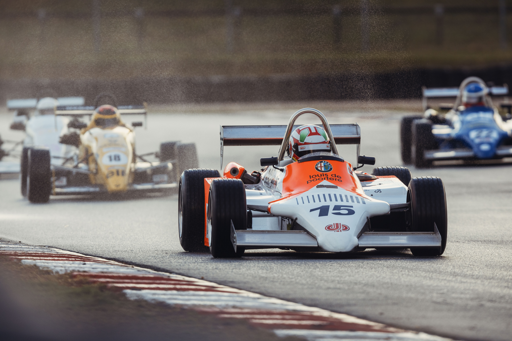

UnboundLocalError: cannot access local variable 'img2' where it is not associated with a value

In [6]:
def visualize_prediction(img, result, conf=0.128):
    """Visualizes the bounding box and segment mask for a YOLOv8 prediction.

    Args:
        img: The original image as a NumPy array.
        result: A single result object from YOLOv8 predictions.
        conf: Confidence threshold for displaying results (default: 0.128).

    Returns:
        The image with overlaid bounding box and mask.
    """

    img3 = Image.fromarray(img)
    img3 = img3.resize((512, int(img3.height // (img3.width / 512))))
    display(img3)


    for box in result.boxes:
        # Extract bounding box coordinates
        left, top, right, bottom = box.xyxy[0].int().tolist()

        # crop image
        img2 = img2[top:bottom, left:right]

        img2 = Image.fromarray(img2)
        img2 = img2.resize((256, int(img2.height // (img2.width / 256))))
        display(img2)

            

for image_path in os.listdir("test_images/"):
    image_path = os.path.join("test_images/", image_path)
    img = Image.open(image_path)
    img_np = np.array(img)  # Convert PIL image to NumPy array
    
    # Perform object detection
    results = model(img, conf=0.128)
    
    # Iterate through the results and draw bounding boxes
    for result in results:
        visualize_prediction(img_np.copy(), result)
           